The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading ../data/cocktail_party/output_data.h5
Loading ../data/cocktail_party/output_data.h5
Generating images for dataset with 3482 samples


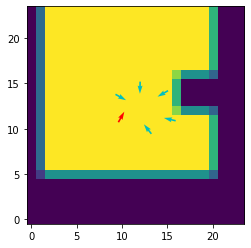

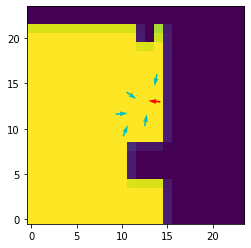

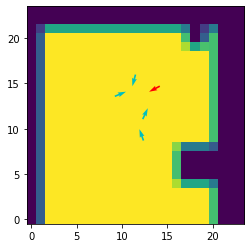

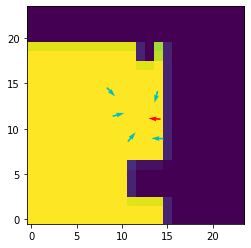

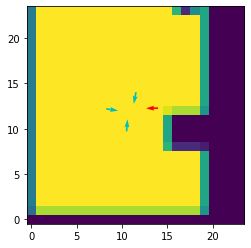

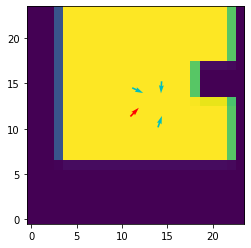

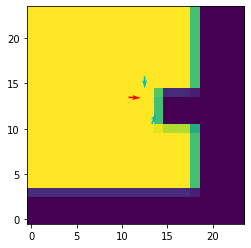

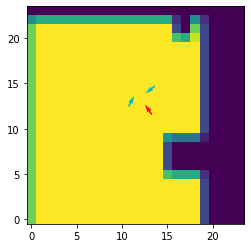

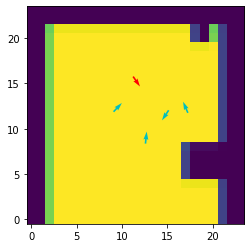

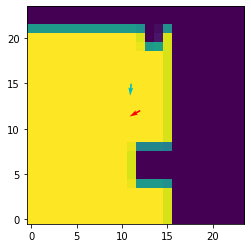

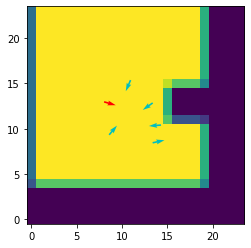

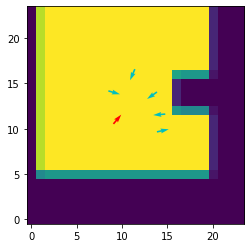

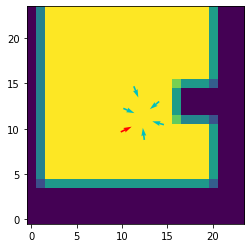

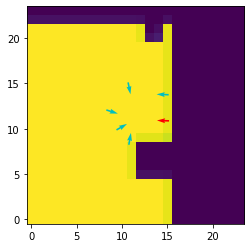

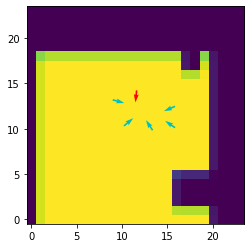

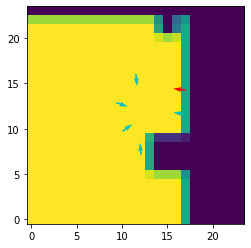

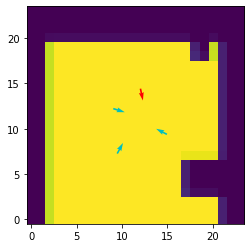

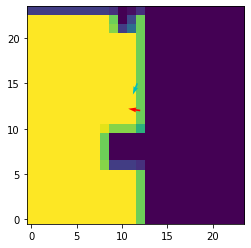

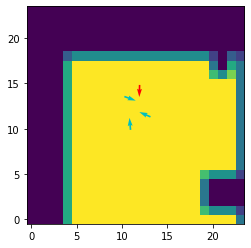

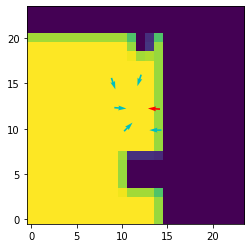

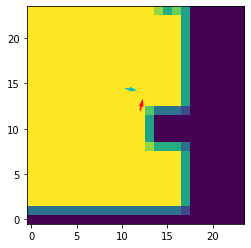

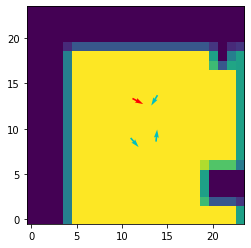

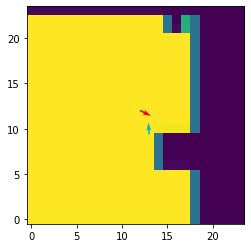

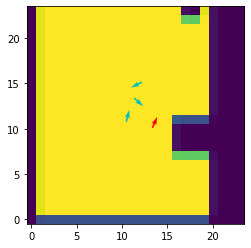

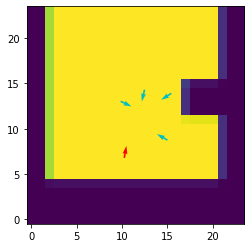

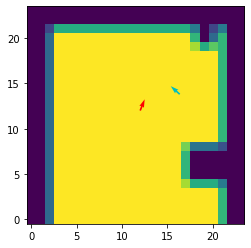

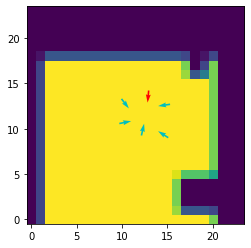

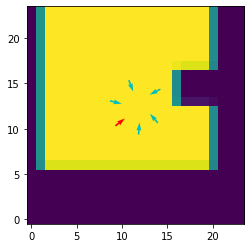

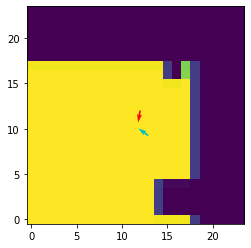

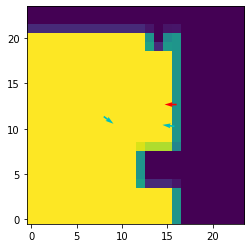

In [21]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

from torch.utils.tensorboard import SummaryWriter
from typing import List
import torch
import json
import numpy as np
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from genff.visualization.plotting import plot_sample_no_map_rect, plot_sample_on_full_map_rect, plot_sample_rect
from genff.gan_method.transform import RectangularAngle
from genff.gan_method.dataset import GroupDataset

from genff.data_handling.transform import TranslateToCentroid
from genff.visualization.plotting import plot_sample, plot_sample_on_full_map
from genff.data_handling.cocktail_gan import CocktailEnvGANDataset
from genff.gan_method.dataset import GroupDataset
from genff.metrics import *
from genff.eval.eval_helpers import compute_results, compute_generator_results
from genff.gan_method.networks import GenNet

def load_args(path):
    # save params
    with open(path, 'r') as fid:
        return json.load(fid)

def log_sample_images(dataset: Dataset, images_indices: List[int], device: torch.device = "cpu", num_samples: int = 20) -> None:
    """
    Helper function to log generated samples to tensorboard
    :param dataset: dataset with images
    :param images_indices: indices of the images to be plotted
    :param device: processing device
    :param num_samples: number of samples to generate per batch example
    """
    transform = RectangularAngle(2)

    with torch.no_grad():

        # make batch of images
        batch_size = len(images_indices)
        ind_list = []
        con_list = []
        mas_list = []
        env_list = []
        for i, ind in enumerate(images_indices):
            sample = dataset[ind]
            ind_list.append(sample[0])
            con_list.append(sample[1])
            mas_list.append(sample[2])
            env_list.append(sample[3])

        individual = torch.stack(ind_list).to(device=device)
        context = torch.stack(con_list).to(device=device)
        mask = torch.stack(mas_list).to(device=device)
        env = torch.stack(env_list).to(device=device)

        # transform batch to rect repr
        individual, context, mask, env = transform((individual, context, mask, env))
        individual = individual.cpu()
        context = context.cpu()
        mask = mask.cpu()

        # plot data
        fig = plt.figure()
        for b in range(batch_size):
            index = int(mask[b,:].sum().tolist() - 1)
            previous_examples = torch.cat((individual[b, :, :], context[b, :index, :], context[b, index+1:, :]))
            current_example = context[b, index, :].unsqueeze(0)

            plot_sample_rect(current_example, previous_examples, mask[b, :], env_cropped=env[b,:,:,:],
                             env_res=dataset.resolution, ind_color="r", mode="free")
            plt.gca().set_aspect('equal')
            plt.show()
#             fig.savefig("../images/generated_{}.png".format(b))

# example loading the same dataset twice...
dataset = GroupDataset(["../data/cocktail_party/output_data.h5",
                        "../data/cocktail_party/output_data.h5"])
print("Generating images for dataset with {} samples".format(len(dataset)))

idx = np.random.choice([x for x in range(len(dataset))], 30, replace=False)
# idx = [x for x in range(0,30)]
log_sample_images(dataset, idx)